In [1]:
using HDF5
using ImageView
using Images
#include("C:/Users/Rutian Zhou/PIV/multi_quickPIV/src/multi_quickPIV.jl")
using Plots

In [5]:
using PyCall

In [6]:
using PyPlot

In [4]:
using multi_quickPIV

In [2]:
file_path = "F:/PhD_Franziska/Headon/RedBeads/single_aggregate1_downwards_cut1.h5"
function read_h5(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end
red_beads = read_h5(file_path, "single_red")

150×140×151 Array{UInt16, 3}:
[:, :, 1] =
 0x0038  0x003f  0x003a  0x0032  0x0041  …  0x003e  0x0040  0x0043  0x003d
 0x003a  0x0039  0x003b  0x003a  0x003e     0x0044  0x0040  0x0042  0x0046
 0x003f  0x003b  0x0040  0x0043  0x003f     0x0043  0x0044  0x003e  0x0036
 0x003c  0x0032  0x003f  0x0041  0x003a     0x0046  0x003b  0x003d  0x0042
 0x0038  0x003e  0x0039  0x0041  0x0045     0x0049  0x003a  0x0043  0x0037
 0x0038  0x003b  0x0039  0x003b  0x0046  …  0x003c  0x003b  0x003b  0x003e
 0x0040  0x0045  0x003e  0x0038  0x003b     0x003d  0x0040  0x003f  0x0041
 0x003a  0x0041  0x003e  0x003f  0x003f     0x0041  0x0042  0x0043  0x0043
 0x004d  0x0063  0x0039  0x0043  0x003a     0x003c  0x0040  0x0038  0x0036
 0x003f  0x0040  0x003f  0x0042  0x0041     0x003e  0x0045  0x003e  0x0038
 0x003a  0x003f  0x003e  0x003b  0x0042  …  0x0044  0x003f  0x003f  0x0044
 0x003c  0x0036  0x003e  0x003e  0x003b     0x0040  0x0047  0x0049  0x0049
 0x0041  0x0046  0x0047  0x0042  0x0046     0x003a  0x0042

In [3]:
ImageView.imshow(Float16.(red_beads[:, :, 1]))

Dict{String, Any} with 4 entries:
  "gui"         => Dict{String, Any}("window"=>GtkWindowLeaf(accessible-role=GT…
  "roi"         => Dict{String, Any}("redraw"=>ObserverFunction[ObserverFunctio…
  "annotations" => Observable(Dict{UInt64, Any}())
  "clim"        => Observable(CLim{Float16}(38.0, 392.0))

## Do PIV only on two images

In [ ]:
# Beacuse of the error appearing in multi_quickPIV: black IS also has a moving direction. 
# Quick and Dirty solution: only consider the IS which is not fully blank!

function index_non_blank(img1::Matrix{Float16})
    # Find out the index if IS which are only 0 or non-zero. 

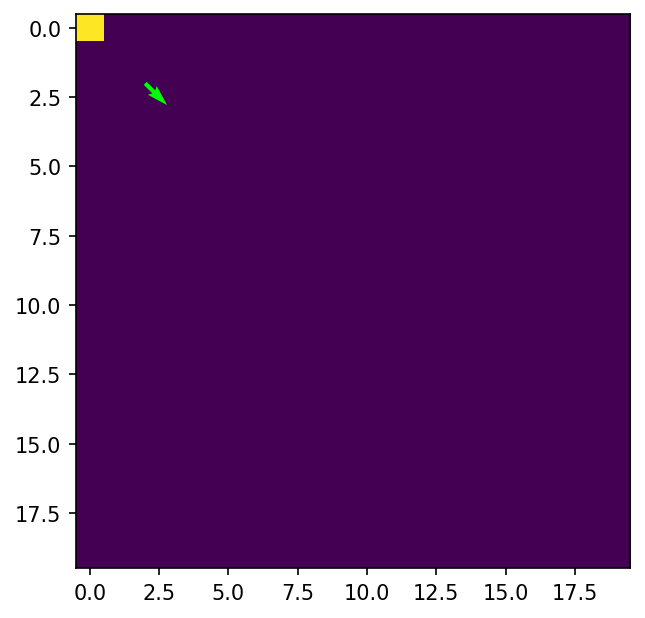

PyObject <matplotlib.quiver.Quiver object at 0x0000015CB2253560>

In [28]:
test_img1 = zeros(20, 20)
test_img1[1, 1] = 1
test_img2 = zeros(20, 20)
test_img2[2,2] = 1

pivparams = multi_quickPIV.setPIVParameters(interSize=(4, 4), searchMargin=(16, 16), step=(2, 2))
VF, _ = multi_quickPIV.PIV( test_img1, test_img2, pivparams, precision=16)

IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

U = VF[ 1, :, : ]; 
V = VF[ 2, :, : ]; 
M = sqrt.( U .^ 2 .+ V .^ 2 ); # Magnitude of the vectors.
ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

PyPlot.figure( dpi=150 ); 

PyPlot.imshow( test_img1 )
PyPlot.quiver( xgrid[1, 1], ygrid[1, 1], V[1, 1], -U[1, 1], color="lime")

## Store the vector field +data into .h5 file. 

In [4]:
params = multi_quickPIV.setPIVParameters(interSize=(16, 16), searchMargin=(32, 32), step=(8, 8))
IA = multi_quickPIV._isize(params)
ST = multi_quickPIV._step(params)

m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:150 #1:size(red_beads, 3)-1
    
    img1 = Float16.(red_beads[:, :, i])
    img2 = Float16.(red_beads[:, :, i+1])

    VF, _ = multi_quickPIV.PIV( img1, img2, params)

    U = VF[ 1, :, : ]
    V = VF[ 2, :, : ]
    M = sqrt.( U .^ 2 .+ V .^ 2 )

    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, M)

    print("tu")
    
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

tutututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututututu

17×16×150 Array{Float32, 3}:
[:, :, 1] =
 28.4473     8.94427  32.2182     1.0       …  32.7567   31.3008   34.176
 28.0487    22.9766    7.67901    1.52831      14.1229   30.3036   31.0483
  2.07231    8.94427   1.72837    1.77406      22.0193   20.1786   14.8638
  2.16576    8.94427  31.8929    28.3632        9.82089  10.349    37.1831
  4.0        8.24621   1.58133    1.76387      26.8363   28.7891   41.0334
  1.93847    9.75591  32.6358     1.81706   …  20.7557   23.0263   25.4677
  1.95905    1.95937  33.5261    40.6079       23.9541   15.07     24.4657
  2.01174   29.6513   18.3208    40.6079       27.2715    2.67419  19.6399
 20.5278     6.60143  15.3497    11.2427       33.672     2.48005  11.4654
  1.39116    7.19902   5.62003    4.13686      17.4833    6.36339   3.76079
  1.10678   15.5512    1.2843     0.916071  …  17.4923   15.9676   27.3628
  0.935869   1.05701   1.03947    0.987385     33.2415   17.4573   19.0857
  1.15141   30.3718    0.796503   0.290339     30.5307   17

In [1]:
m_U[1]

LoadError: UndefVarError: `m_U` not defined

In [5]:
h5open("piv_single_aggregate1_downwards_cut1", "w") do file
    write(file, "U", U_data)
    write(file, "V", V_data)
    write(file, "xgrid", xgrid_data)
    write(file, "ygrid", ygrid_data)
    write(file, "M", M_data)
end

BoundsError: BoundsError: attempt to access empty String at index [1:44]